In [162]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# noinspection PyUnresolvedReferences
import tensorflow.keras as tk
# noinspection PyUnresolvedReferences
import tensorflow.keras.layers as l
# noinspection PyUnresolvedReferences
from tensorflow.keras.backend import clear_session
# noinspection PyUnresolvedReferences
from tensorflow.keras.models import clone_model
# noinspection PyUnresolvedReferences
from tensorflow.keras.utils import to_categorical

from utils import sub_percentage_of, plot_accuracy_and_loss

In [ ]:
import os

working_locally = not os.path.exists('/kaggle/working') and not os.path.exists('/content')

In [179]:
if working_locally:
    train_path = "mitbih_train.csv"
    test_path = "mitbih_test.csv"
else:
    train_path = "/kaggle/input/heartbeat/mitbih_train.csv"
    test_path = "/kaggle/input/heartbeat/mitbih_test.csv"

train_df = pd.read_csv(train_path, header=None)
test_df = pd.read_csv(test_path, header=None)

test_df.index = test_df.index + train_df.shape[0]

all_data = pd.concat([train_df, test_df])

all_data.rename(columns={187: 'class'}, inplace=True)

# Basic EDA

In [180]:
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [139]:
all_data['class'].value_counts()

0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: class, dtype: int64

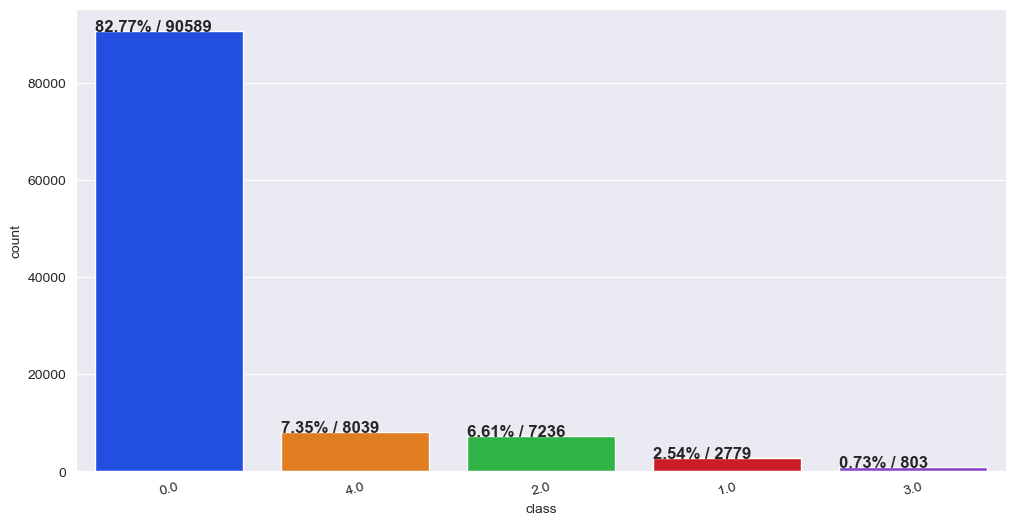

In [140]:
percentages = [count / all_data.shape[0] * 100 for count in all_data['class'].value_counts()]

fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(
    x=all_data['class'],
    ax=ax,
    palette="bright",
    order=all_data['class'].value_counts().index
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=15);

for percentage, count, p in zip(
        percentages,
        all_data['class'].value_counts(sort=True).values,
        ax.patches):
    percentage = f'{np.round(percentage, 2)}%'
    x = p.get_x() + p.get_width() / 2 - 0.4
    y = p.get_y() + p.get_height()
    ax.annotate(str(percentage) + " / " + str(count), (x, y), fontsize=12, fontweight='bold')

In [141]:
train_final = all_data[all_data.index < train_df.shape[0]]
test_final = all_data[all_data.index >= train_df.shape[0]]

In [142]:
train_final.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [143]:
test_final.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
87554,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87555,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87556,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87557,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87558,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
train_final.shape

(87554, 188)

In [145]:
test_final.shape

(21892, 188)

# Models

In [146]:
class_names =  ["Normal", "Artial Premature", "Premature ventricular contraction", "Fusion of ventricular and normal", "Fusion of paced and normal"]
number_of_features = 187

In [147]:
def build_model():
    model = tk.Sequential([
        l.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.LSTM(128, return_sequences=True),
        l.LSTM(128),
        l.Dense(len(class_names), activation="softmax")
    ])
    optimizer = tk.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
    return model


# Training stage

In [164]:
from sklearn.model_selection import train_test_split



X = train_final.iloc[:, :-1].values
y = train_final.iloc[:, -1].values

y = to_categorical(y, num_classes=len(class_names))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = test_final.iloc[:, :-1].values
y_test = test_final.iloc[:, -1].values
y_test = to_categorical(y_test, num_classes=len(class_names))

In [165]:
if working_locally:
    X_train, y_train = sub_percentage_of(X_train, y_train, 0.05)
    X_valid, y_valid = sub_percentage_of(X_valid, y_valid, 0.05)
    X_test, y_test = sub_percentage_of(X_test, y_test, 0.05)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3502, 187) (3502, 5)
(1094, 187) (1094, 5)


In [166]:
def build_model():
    model = tk.Sequential([
        l.Conv1D(32, kernel_size=5, strides=2, activation="relu", input_shape=(187, 1)),
        l.BatchNormalization(),
        l.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
        l.BatchNormalization(),
        l.LSTM(128, return_sequences=True),
        l.LSTM(128),
        l.Dense(len(class_names), activation="softmax")
    ])
    optimizer = tk.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
    model.compile(loss="categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    return model


In [167]:
model = build_model()
early_stopping = tk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/10
110/110 [==============================] - 13s 58ms/step - loss: 0.7813 - accuracy: 0.7953 - val_loss: 0.9537 - val_accuracy: 0.8263
Epoch 2/10
110/110 [==============================] - 5s 45ms/step - loss: 0.6427 - accuracy: 0.8281 - val_loss: 0.7650 - val_accuracy: 0.8263
Epoch 3/10
110/110 [==============================] - 5s 45ms/step - loss: 0.5974 - accuracy: 0.8281 - val_loss: 0.7138 - val_accuracy: 0.8263
Epoch 4/10
110/110 [==============================] - 5s 45ms/step - loss: 0.5512 - accuracy: 0.8298 - val_loss: 0.6589 - val_accuracy: 0.8263
Epoch 5/10
110/110 [==============================] - 5s 47ms/step - loss: 0.4982 - accuracy: 0.8487 - val_loss: 0.5709 - val_accuracy: 0.8331
Epoch 6/10
110/110 [==============================] - 6s 52ms/step - loss: 0.4488 - accuracy: 0.8746 - val_loss: 0.4921 - val_accuracy: 0.8457
Epoch 7/10
110/110 [==============================] - 8s 71ms/step - loss: 0.4100 - accuracy: 0.8864 - val_loss: 0.4442 - val_accuracy: 0.869

In [168]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 1s 17ms/step - loss: 0.1202 - accuracy: 0.9854


[0.12023133784532547, 0.9853747487068176]

In [153]:
model.save('model.h5')

### retraining using a balanced dataset

In [154]:
from sklearn.utils import resample


def get_balanced_data():
    class0_df = train_df[train_df[187] == 0]
    class1_df = train_df[train_df[187] == 1]
    class2_df = train_df[train_df[187] == 2]
    class3_df = train_df[train_df[187] == 3]
    class4_df = train_df[train_df[187] == 4]

    class1_up_sampled = resample(class1_df, n_samples=20000, replace=True, random_state=1)
    class2_up_sampled = resample(class2_df, n_samples=20000, replace=True, random_state=1)
    class3_up_sampled = resample(class3_df, n_samples=20000, replace=True, random_state=1)
    class4_up_sampled = resample(class4_df, n_samples=20000, replace=True, random_state=1)

    class0_down_sampled = class0_df.sample(n=20000, random_state=0)

    return pd.concat([class0_down_sampled,
                      class1_up_sampled,
                      class2_up_sampled,
                      class3_up_sampled,
                      class4_up_sampled])


In [155]:
balanced_train_df = get_balanced_data()

In [156]:
X = balanced_train_df.iloc[:, :-1].values
y = balanced_train_df.iloc[:, -1].values

y = to_categorical(y, num_classes=len(class_names))

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [157]:
if working_locally:
    X_train, y_train = sub_percentage_of(X_train, y_train, 0.05)
    X_valid, y_valid = sub_percentage_of(X_valid, y_valid, 0.05)

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(4000, 187) (4000, 5)
(1000, 187) (1000, 5)


In [178]:
model = build_model()
early_stopping = tk.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping])

Epoch 1/10
110/110 [==============================] - 12s 56ms/step - loss: 0.7940 - accuracy: 0.7933 - val_loss: 1.0363 - val_accuracy: 0.8263
Epoch 2/10
110/110 [==============================] - 5s 44ms/step - loss: 0.6311 - accuracy: 0.8281 - val_loss: 0.9241 - val_accuracy: 0.8263
Epoch 3/10
110/110 [==============================] - 5s 45ms/step - loss: 0.5874 - accuracy: 0.8281 - val_loss: 0.9067 - val_accuracy: 0.8263
Epoch 4/10
110/110 [==============================] - 5s 46ms/step - loss: 0.5526 - accuracy: 0.8312 - val_loss: 0.8522 - val_accuracy: 0.8263
Epoch 5/10
110/110 [==============================] - 5s 46ms/step - loss: 0.5146 - accuracy: 0.8452 - val_loss: 0.6795 - val_accuracy: 0.8377
Epoch 6/10
110/110 [==============================] - 5s 45ms/step - loss: 0.4755 - accuracy: 0.8595 - val_loss: 0.5208 - val_accuracy: 0.8469
Epoch 7/10
110/110 [==============================] - 5s 44ms/step - loss: 0.4383 - accuracy: 0.8746 - val_loss: 0.4946 - val_accuracy: 0.840

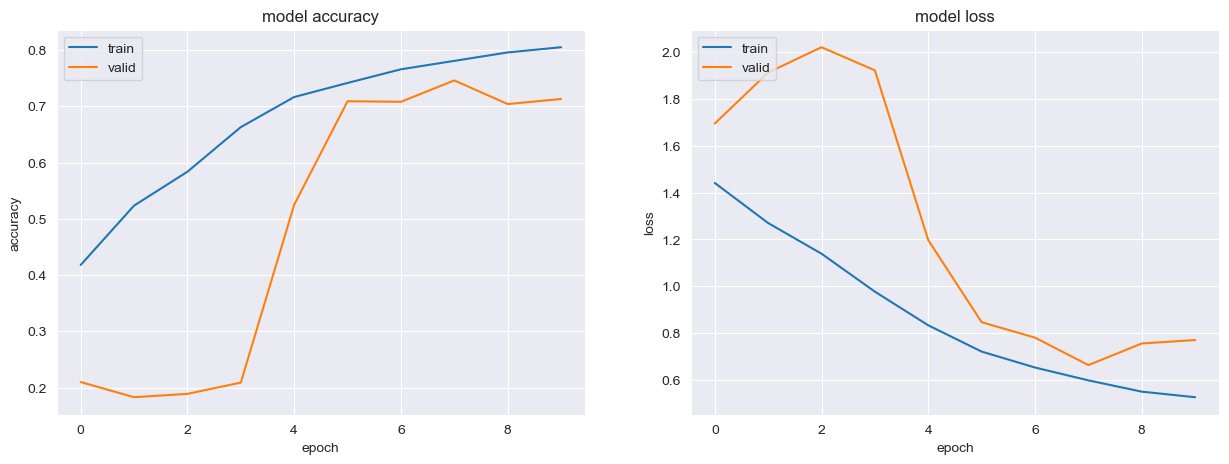

In [159]:
plot_accuracy_and_loss(history)

In [160]:
model.evaluate(X_test, y_test)

35/35 [==============================] - 1s 15ms/step - loss: 0.9306 - accuracy: 0.5530


[0.9306069016456604, 0.5530164241790771]

In [161]:
model.save('model_trained_on_balanced_data.h5')